Trial Inclusion Criteria: {'age_range': (50, 70), 'conditions': ['diabetes'], 'medications': ['metformin']}
Trial Exclusion Criteria: {'conditions': ['heart disease'], 'pregnant': True}
--------------------------------------------------
Example Generated Patient: {'age': 32, 'conditions': ['heart disease'], 'medications': ['none'], 'pregnant': True}
--------------------------------------------------
Label for example patient: -1
--------------------------------------------------
Extracted Entities from example patient: {'heart disease', 'none', 'pregnant', '32'}
Extracted Trial Entities: {'metformin', 'not pregnant', 'age', 'diabetes'}
--------------------------------------------------
Sørensen-Dice similarity score (example patient vs trial): 0.0
--------------------------------------------------
Total patients after filtering (label != 0): 666
First 5 patients: [{'age': 63, 'conditions': ['heart disease'], 'medications': ['metformin'], 'pregnant': False}, {'age': 78, 'conditions': ['

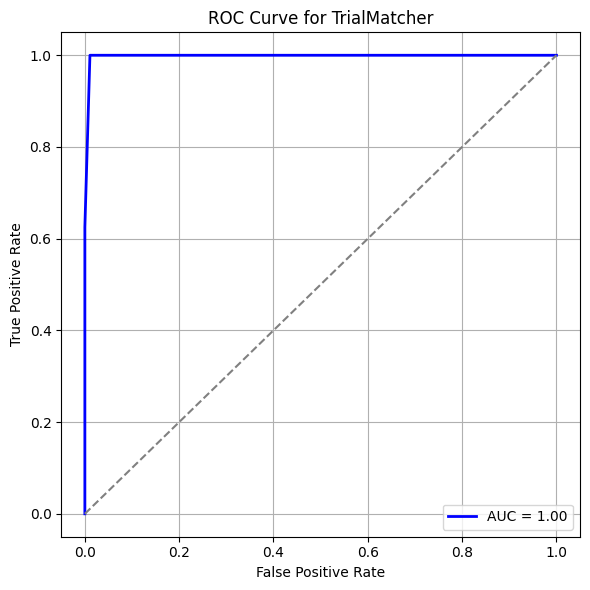

In [2]:
import random
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ---------------------------
# STEP 1: Define trial criteria
# ---------------------------
trial_inclusion = {"age_range": (50, 70), "conditions": ["diabetes"], "medications": ["metformin"]}
trial_exclusion = {"conditions": ["heart disease"], "pregnant": True}

print("Trial Inclusion Criteria:", trial_inclusion)
print("Trial Exclusion Criteria:", trial_exclusion)
print("-" * 50)

# ---------------------------
# STEP 2: Generate synthetic patients
# ---------------------------
def generate_patient():
    age = random.randint(30, 80)
    conditions = random.sample(["diabetes", "heart disease", "asthma", "PTSD", "none"], k=random.randint(1, 2))
    medications = random.sample(["metformin", "insulin", "none"], k=1)
    pregnant = random.choice([True, False])
    return {
        "age": age,
        "conditions": conditions,
        "medications": medications,
        "pregnant": pregnant
    }

# Example generation
example_patient = generate_patient()
print("Example Generated Patient:", example_patient)
print("-" * 50)

# ---------------------------
# STEP 3: Label each patient
# ---------------------------
def assign_label(patient):
    inclusion_match = (
        trial_inclusion["age_range"][0] <= patient["age"] <= trial_inclusion["age_range"][1] and
        "diabetes" in patient["conditions"] and
        "metformin" in patient["medications"]
    )
    exclusion_match = (
        "heart disease" in patient["conditions"] or
        (trial_exclusion["pregnant"] and patient["pregnant"])
    )
    if inclusion_match and not exclusion_match:
        return 1  # perfect match
    elif exclusion_match and not inclusion_match:
        return -1  # definite non-match
    else:
        return 0  # unknown/partial

example_label = assign_label(example_patient)
print("Label for example patient:", example_label)
print("-" * 50)

# ---------------------------
# STEP 4: Extract Entities (NER mimic)
# ---------------------------
def extract_entities(patient):
    entities = set(patient["conditions"] + patient["medications"] + [str(patient["age"]), "pregnant" if patient["pregnant"] else "not pregnant"])
    return entities

def extract_trial_entities():
    entities = set()
    entities.update(trial_inclusion["conditions"])
    entities.update(trial_inclusion["medications"])
    entities.update(["age", "not pregnant"])
    return entities

example_entities = extract_entities(example_patient)
trial_entities = extract_trial_entities()
print("Extracted Entities from example patient:", example_entities)
print("Extracted Trial Entities:", trial_entities)
print("-" * 50)

# ---------------------------
# STEP 5: Compute Sørensen-Dice Index
# ---------------------------
def sorensen_dice(a, b):
    intersection = len(a & b)
    return (2 * intersection) / (len(a) + len(b)) if (len(a) + len(b)) > 0 else 0

example_score = sorensen_dice(example_entities, trial_entities)
print("Sørensen-Dice similarity score (example patient vs trial):", example_score)
print("-" * 50)

# ---------------------------
# STEP 6: Simulate and Evaluate
# ---------------------------

patients = []
labels = []
scores = []

for i in range(1000):
    p = generate_patient()
    label = assign_label(p)
    if label == 0:
        continue  # skip unknowns for ROC
    patients.append(p)
    labels.append(label)

    patient_entities = extract_entities(p)
    score = sorensen_dice(patient_entities, trial_entities)
    scores.append(score)

print(f"Total patients after filtering (label != 0): {len(patients)}")
print(f"First 5 patients:", patients[:5])
print(f"First 5 labels:", labels[:5])
print(f"First 5 similarity scores:", scores[:5])
print("-" * 50)

# ---------------------------
# STEP 7: Compute ROC and AUC
# ---------------------------

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

print("False Positive Rates:", fpr[:5])
print("True Positive Rates:", tpr[:5])
print("Thresholds:", thresholds[:5])
print(f"Computed AUC: {roc_auc:.3f}")
print("-" * 50)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for TrialMatcher')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import random
import pandas as pd
from difflib import SequenceMatcher

# Simulate a population of patients
population_size = 100
population = pd.DataFrame({
    'patient_id': range(1, population_size + 1),
    'age': [random.randint(18, 80) for _ in range(population_size)],
    'condition': random.choices(['Healthy', 'Mild', 'Severe'], k=population_size)
})

# Eligibility criteria: include only patients aged 20–60 and non-severe
study_population = population[
    (population['age'] >= 20) &
    (population['age'] <= 60) &
    (population['condition'] != 'Severe')
].reset_index(drop=True)

# Randomly assign to two groups
study_population['group'] = random.choices(['Group_20mg', 'Group_50mg'], k=len(study_population))

# Group metadata
arm_description = {
    'Group_20mg': '20 mg VEC-162 capsules, PO daily for five weeks',
    'Group_50mg': '50 mg VEC-162 capsules, PO daily for five weeks'
}

# Simulated ADEs
ade_reports = {
    'Group_20mg': ['Infections', 'Nervous system disorders'],
    'Group_50mg': ['Infections', 'Nervous system disorders', 'Investigations']
}

# Triplet structure for linking: (intervention, ADE description, ADE group)
def create_triplets(group, description, ade_list):
    return [(group, description, ade) for ade in ade_list]

triplets = []
for group, ades in ade_reports.items():
    desc = arm_description[group]
    triplets.extend(create_triplets(group, desc, ades))

# Link arms and ADEs by fuzzy match
def fuzzy_match(a, b, threshold=0.8):
    return SequenceMatcher(None, a, b).ratio() > threshold

# Example matching: new description or report coming in
new_ade_input = 'infections and infestations'
linked = []

for group, desc, ade in triplets:
    if fuzzy_match(ade.lower(), new_ade_input.lower()):
        linked.append((group, desc, ade))

# Output
print("\nSample study population:")
print(study_population.head())

print("\nGenerated triplets:")
for t in triplets:
    print(t)

print("\nMatched ADE triplet for input '{}':".format(new_ade_input))
for match in linked:
    print(match)



Sample study population:
   patient_id  age condition       group
0           2   60   Healthy  Group_20mg
1           3   24      Mild  Group_50mg
2           5   46      Mild  Group_50mg
3           8   57      Mild  Group_50mg
4          10   58   Healthy  Group_50mg

Generated triplets:
('Group_20mg', '20 mg VEC-162 capsules, PO daily for five weeks', 'Infections')
('Group_20mg', '20 mg VEC-162 capsules, PO daily for five weeks', 'Nervous system disorders')
('Group_50mg', '50 mg VEC-162 capsules, PO daily for five weeks', 'Infections')
('Group_50mg', '50 mg VEC-162 capsules, PO daily for five weeks', 'Nervous system disorders')
('Group_50mg', '50 mg VEC-162 capsules, PO daily for five weeks', 'Investigations')

Matched ADE triplet for input 'infections and infestations':


In [5]:
import numpy as np
import pandas as pd
x = np.matrix(np.random.rand(1,100,1))
x
y=np.matrix(np.random.rand(1,100,1))
y

matrix([[0.95080863, 0.27039172, 0.03793041, 0.69478957, 0.06621212,
         0.32643002, 0.18719977, 0.35556899, 0.65394178, 0.76050747,
         0.06114425, 0.94110101, 0.87770768, 0.70709033, 0.45526006,
         0.23188184, 0.11725153, 0.22681636, 0.78936071, 0.74302635,
         0.77768864, 0.64714935, 0.90974676, 0.75285242, 0.84918386,
         0.60412019, 0.62968688, 0.89338037, 0.39247604, 0.70991637,
         0.04738145, 0.92349354, 0.24309603, 0.76710834, 0.10209196,
         0.51779275, 0.44439524, 0.20269952, 0.24200556, 0.33697452,
         0.22687418, 0.83734531, 0.58125978, 0.96870871, 0.47990834,
         0.1246614 , 0.90228986, 0.21686089, 0.67715457, 0.15936792,
         0.90112306, 0.29375706, 0.47116375, 0.60293624, 0.98226701,
         0.10087013, 0.95684527, 0.84056614, 0.50822261, 0.14784868,
         0.55947897, 0.68751728, 0.72863533, 0.26943689, 0.23510891,
         0.60406712, 0.46870896, 0.29449742, 0.19469956, 0.29978275,
         0.64396591, 0.80766423, 0

In [6]:
import numpy as np

# Sample data
# Let's predict y using two predictors: x1 and x2
# y = b0 + b1*x1 + b2*x2
X = np.array([
    [1, 1, 2],  # First 1 is for the intercept term
    [1, 2, 3],
    [1, 4, 5],
    [1, 3, 6],
    [1, 5, 8]
])

y = np.array([5, 8, 14, 13, 20])  # Outcome vector

# Step 1: Compute beta = (X^T X)^-1 X^T y
X_transpose = X.T
beta = np.linalg.inv(X_transpose @ X) @ X_transpose @ y

# Step 2: Predict values
y_pred = X @ beta

# Step 3: Output results
print("Estimated coefficients (b0, b1, b2):", beta)
print("Predicted values:", y_pred)


Estimated coefficients (b0, b1, b2): [0.525 2.025 1.125]
Predicted values: [ 4.8   7.95 14.25 13.35 19.65]


In [7]:
X = np.random.rand(100, 2)

In [8]:
X

array([[0.54418252, 0.96232079],
       [0.85451073, 0.8382788 ],
       [0.02434805, 0.81406646],
       [0.42756921, 0.4262126 ],
       [0.18721711, 0.21155076],
       [0.7968755 , 0.05475251],
       [0.3046044 , 0.41702506],
       [0.27989852, 0.71109892],
       [0.97439891, 0.67895689],
       [0.38021318, 0.17700458],
       [0.40971412, 0.98190153],
       [0.42237897, 0.83862463],
       [0.53651419, 0.64021609],
       [0.12514618, 0.75678743],
       [0.24844201, 0.37190928],
       [0.93369714, 0.24933165],
       [0.72469338, 0.40208227],
       [0.85094523, 0.14773386],
       [0.13322091, 0.79581649],
       [0.07813455, 0.82664321],
       [0.14133357, 0.99321602],
       [0.23918301, 0.75356186],
       [0.79122369, 0.41399244],
       [0.65471141, 0.90875947],
       [0.65093225, 0.61558388],
       [0.82192354, 0.70120374],
       [0.36713729, 0.55089187],
       [0.06681217, 0.53749941],
       [0.25465803, 0.83847889],
       [0.13710261, 0.25468079],
       [0.

In [ ]:
pip install https://huggingface.co/allenai/scispacy_models/resolve/main/en_ner_bionlp13cg_md-0.5.2.tar.gz


User for huggingface.co: 

In [ ]:
pip install spacy scispacy